In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression,LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import Sequential
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Precision, Recall



from collections import Counter
from sklearn.metrics import roc_curve, auc,accuracy_score
import pickle
from sklearn.decomposition import PCA

from datetime import datetime
from datetime import date


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [14]:
btc_hourly_return = pd.read_csv('btc_hourly_return_selected.csv')
btc_hourly_return.index =pd.to_datetime(btc_hourly_return['timestamp'])
btc_hourly_return.drop(columns=['timestamp'],inplace=True)
#btc_min_return=btc_min_return[btc_min_return.index > '2019']
btc_hourly_return['return_scaled'] = btc_hourly_return['return']*100

features_removed = ['return','return_scaled','J_test_statistic', 'jump_detected_3_3','jump_size_3_3','RV_d','log1+J','RS','scale_right','shape_right','scale_left','shape_left']
features = btc_hourly_return.columns.to_list()
features = [item for item in features if item not in features_removed]
TI_features = features[:6]+features[-17:]
SV_features = features[:-17]
Naive_features = features[:6]

In [49]:
btc_daily_return = pd.read_csv('btc_daily_return_selected.csv')
btc_daily_return.index =pd.to_datetime(btc_daily_return['timestamp'])
btc_daily_return.drop(columns=['timestamp'],inplace=True)
#btc_min_return=btc_min_return[btc_min_return.index > '2019']
btc_daily_return['return_scaled'] = btc_daily_return['return']*100

features_removed = ['return','return_scaled','J_test_statistic', 'jump_detected_3_3','jump_size_3_3','RV_d','log1+J','RS','scale_right','shape_right','scale_left','shape_left']
features = btc_daily_return.columns.to_list()
features = [item for item in features if item not in features_removed]
TI_features = features[:6]+features[-17:]
SV_features = features[:-17]
Naive_features = features[:6]

### Generate labels

In [50]:
quantile_upper = 0.8
quantile_lower = 1-quantile_upper
accuracy_metric = 'Build_in_acc'
target_used = 'target_quantile'

In [51]:
# Create the target variable -- Quantile based threshold
df = btc_daily_return.copy()[features+['return_scaled','return']]

upper_quantile = df['return_scaled'].quantile(quantile_upper)
lower_quantile = df['return_scaled'].quantile(quantile_lower)
df['target_quantile'] = 0
df.loc[df['return_scaled'].shift(-1) > upper_quantile, 'target_quantile'] = 1
df.loc[df['return_scaled'].shift(-1) < lower_quantile, 'target_quantile'] = -1
df = df.dropna()
print([upper_quantile,lower_quantile])

[0.03919483220352, -0.051800631653960004]


In [53]:
X = df[features]
y = df[target_used]

# Split the data into training and test sets
cutoff_date = '2021-01-01'
X_train = X[df.index < cutoff_date]
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = X[df.index >= cutoff_date]
scaler = StandardScaler()
X_test= scaler.fit_transform(X_test)
y_train = y[df.index < cutoff_date]
y_test = y[df.index >= cutoff_date]

X_TI = df[TI_features]
X_train_TI = X_TI[df[TI_features].index < cutoff_date]
scaler = StandardScaler()
X_train_TI= scaler.fit_transform(X_train_TI)
X_test_TI = X_TI[df[TI_features].index >= cutoff_date]
scaler = StandardScaler()
X_test_TI= scaler.fit_transform(X_test_TI)

X_SV = df[SV_features]
scaler = StandardScaler()
X_SV= scaler.fit_transform(X_SV)
X_train_SV = X_SV[df[SV_features].index < cutoff_date]
X_test_SV = X_SV[df[SV_features].index >= cutoff_date]

X_Naive = df[Naive_features]
scaler = StandardScaler()
X_Naive= scaler.fit_transform(X_Naive)
X_train_Naive = X_Naive[df[Naive_features].index < cutoff_date]
X_test_Naive = X_Naive[df[Naive_features].index >= cutoff_date]

### Define Accuracy metrics

- Type I error: FP (reject null while null is true)

- Type II error: FN (not reject null while null is not true)

- Precision: $\frac{TP}{TP + FP}$

- Recall: $\frac{TP}{TP + FN}$

- F1-Score: $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

- Accuracy_function:

$\text{Profit}-\text{accuracy} = \frac{TD + TI}{TD + TI + FDN+FIN+FID+FDI}$;

s.t.
TD: the number of true predictions decreases; FDN: the number of predictions of the no-action class decreases; FDI: the number of predictions of the increase class decreases and etc.




In [54]:
def custom_accuracy(y_true, y_pred):
    Accuracy = {}
    
    # Acc_True: Standard accuracy
    Accuracy['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Round the accuracy values to 2 decimal places
    Acc = {k: round(v, 2) for k, v in Accuracy.items()}
    
    # Return the accuracies as a DataFrame
    return pd.DataFrame([Acc])


### LSTM

In [55]:
def custom_f1_score(y_true, y_pred):
    # Ensure y_true and y_pred are of integer type
    y_true = K.cast(y_true, 'int32')
    y_pred = K.argmax(y_pred, axis=-1)
    
    # Convert to one-hot encoding for F1 score calculation
    num_classes = tf.reduce_max(y_true) + 1
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
    y_pred_one_hot = tf.one_hot(y_pred, depth=num_classes)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true_one_hot) * y_pred_one_hot, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true_one_hot * (1 - y_pred_one_hot), 'float32'), axis=0)
    
    # Calculate Precision, Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Return the average F1 score across all classes
    return K.mean(f1)

def custom_precision(y_true, y_pred):
    y_true = K.cast(y_true, 'int32')
    y_pred = K.argmax(y_pred, axis=-1)
    num_classes = tf.reduce_max(y_true) + 1
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
    y_pred_one_hot = tf.one_hot(y_pred, depth=num_classes)
    tp = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true_one_hot) * y_pred_one_hot, 'float32'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    return K.mean(precision)

def custom_recall(y_true, y_pred):
    # Ensure y_true and y_pred are of integer type
    y_true = K.cast(y_true, 'int32')
    y_pred = K.argmax(y_pred, axis=-1)
    
    # Convert to one-hot encoding for recall calculation
    num_classes = tf.reduce_max(y_true) + 1
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)
    y_pred_one_hot = tf.one_hot(y_pred, depth=num_classes)
    
    # Calculate True Positives and False Negatives
    tp = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true_one_hot * (1 - y_pred_one_hot), 'float32'), axis=0)
    
    # Calculate Recall for each class
    recall = tp / (tp + fn + K.epsilon())
    
    # Return the average Recall across all classes
    return K.mean(recall)

def custom_auc(y_true, y_pred):
    # Ensure y_true and y_pred are of integer type
    y_true = K.cast(y_true, 'int32')
    y_pred = tf.nn.softmax(y_pred)  # Convert logits to probabilities
    
    # Define AUC metric
    auc_metric = tf.keras.metrics.AUC()
    
    # Update the metric with the true labels and predictions
    auc_metric.update_state(y_true, y_pred)
    
    # Return the result of AUC
    return auc_metric.result()


def plot_metrics(history, metric='accuracy'):
 
    plt.figure(figsize=(6, 3))  # Adjust the figure size

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation accuracy (or other metric)
    plt.subplot(1, 2, 2)
    if metric == 'accuracy':
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
    else:
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.tight_layout()
    plt.show()

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def build_and_train_lstm(X_train, y_train, X_test, y_test, 
                         epochs=50, patience=6, learning_rate=0.005, 
                         metric=custom_f1_score, 
                         plot_metrics_flag=False):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encoding the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Reshaping the input data for LSTM
    X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Calculating class weights to handle imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weight_dict = dict(enumerate(class_weights))

    # Building the LSTM model
    model = build_lstm_model(input_shape=(1, X_train_scaled.shape[1]), num_classes=len(label_encoder.classes_))

    # Compiling the model with the specified optimizer and loss function
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=[metric,'accuracy'])
    
    # Setting up early stopping to prevent overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    # Training the model
    history = model.fit(X_train_lstm, y_train_encoded,
                        epochs=epochs,
                        batch_size=64,
                        verbose=2,
                        validation_data=(X_test_lstm, y_test_encoded),
                        callbacks=[early_stopping_callback],
                        class_weight=class_weight_dict)

    # Plotting the metrics if the flag is set
    if plot_metrics_flag:
        plot_metrics(history, metric='accuracy')  # This will plot both loss and accuracy curves

    # Making predictions on the test set
    y_pred_prob = model.predict(X_test_lstm)
    y_pred_encoded = np.argmax(y_pred_prob, axis=1)
    y_pred_class = label_encoder.inverse_transform(y_pred_encoded)

    return y_pred_prob, y_pred_class


def evaluate_lstm_model(X_train, y_train, X_test, y_test, 
                        epochs_list, metric_list, learning_rate_list):
    results = {}

    # Iterate through each combination of epochs, metrics, and learning rates
    for metric in metric_list:
        for learning_rate in learning_rate_list:
            for epochs in epochs_list:
                print(f'\nTraining with {epochs} epochs, learning rate {learning_rate}, and metrics {metric.__name__}...\n')

                # Train the LSTM model with the specified parameters
                y_pred_prob, y_pred_class = build_and_train_lstm(
                    X_train, y_train, X_test, y_test,
                    epochs=epochs,
                    learning_rate=learning_rate,
                    metric=metric
                )

                # Manually calculate custom accuracy (assuming the function takes y_true and y_pred as np arrays)
                custom_acc = custom_accuracy(y_test, y_pred_class)
                print(f'Custom accuracy: {custom_acc}')
                
                # Store results
                results[(metric.__name__, learning_rate, epochs)] = {
                    'custom_acc': custom_acc,
                    'y_pred_prob': y_pred_prob,
                    'y_pred_class': y_pred_class,
                    'custom_accuracies_df': custom_acc
                }

    return results



In [56]:
def create_hybrid_predictions(y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI):
    final_predictions = []
    final_probabilities = []

    for pred_SV, prob_SV, pred_TI, prob_TI in zip(y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI):
        if pred_SV == 0 or pred_TI == 0:
            # If either model predicts class-noact (0), the final decision is class-noact (0)
            final_predictions.append(0)
            final_probabilities.append(prob_SV)  # No active probabilities
        elif pred_SV == pred_TI:
            # If both models agree on the label, use that label
            final_predictions.append(pred_SV)
            final_probabilities.append(prob_SV)  
        else:
            # If predictions are different, compare the probabilities for the predicted classes
            prob_SV_pred = prob_SV[np.argmax(prob_SV)]  # Probability for the class predicted by SV
            prob_TI_pred = prob_TI[np.argmax(prob_TI)]  # Probability for the class predicted by TI
            
            if prob_SV_pred > prob_TI_pred:
                final_predictions.append(pred_SV)
                final_probabilities.append(prob_SV)
            elif prob_SV_pred < prob_TI_pred:
                final_predictions.append(pred_TI)
                final_probabilities.append(prob_TI)
            else:
                # If probabilities are the same, choose the SV model's prediction
                final_predictions.append(pred_SV)
                final_probabilities.append(prob_SV)
    
    return np.array(final_predictions), np.array(final_probabilities)

def generate_hybrid_predictions(metric_list,learn_rate_list, epochs_list, results_SV, results_TI, create_hybrid_predictions):
    # Initialize a dictionary to store hybrid results
    results_Hybrid = {}

    # Iterate through each epoch to generate hybrid predictions
    for metric in metric_list:
        for learning_rate in learn_rate_list:
            for epochs in epochs_list:
                y_pred_class_SV = results_SV[(metric.__name__, learning_rate, epochs)]['y_pred_class']
                y_pred_prob_SV = results_SV[(metric.__name__, learning_rate, epochs)]['y_pred_prob']
                y_pred_class_TI = results_TI[(metric.__name__, learning_rate, epochs)]['y_pred_class']
                y_pred_prob_TI = results_TI[(metric.__name__, learning_rate, epochs)]['y_pred_prob']

        # Generate hybrid predictions and probabilities
        hybrid_pred_class, hybrid_pred_prob = create_hybrid_predictions(
            y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI
        )

        # Store hybrid results for this epoch
        results_Hybrid[(metric.__name__, learning_rate, epochs)] = {
            'y_pred_class': hybrid_pred_class,
            'y_pred_prob': hybrid_pred_prob
        }
    
    return results_Hybrid



def create_trade_summary(y_true, results, metric_list,learn_rate_list, epochs_list, models):
    summary_data = []

    for metric in metric_list:
        for learning_rate in learn_rate_list:
            for epochs in epochs_list:
                row_data = {('metric', 'learning_rate', 'epochs'): (metric.__name__, learning_rate, epochs)}

                for model in models:
                    y_pred_class = results[model][(metric.__name__, learning_rate, epochs)]['y_pred_class']
                    acc = np.round(accuracy_score(y_true, y_pred_class),2)

                    count = Counter(y_pred_class)
                    pos_trade_count = count.get(1, 0)  # Positive trades count
                    neg_trade_count = count.get(-1, 0)  # Negative trades count (if -1 is in the labels)
                    no_action_count = count.get(0, 0)  # No-action count (if 0 is in the labels)
                    total_transac = pos_trade_count + neg_trade_count 
                    total_transac_ptc = total_transac / (total_transac + no_action_count) 
                    pos_trade_ptc = f"{(pos_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
                    neg_trade_ptc = f"{(neg_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
                    total_transac_ptc = f"{(total_transac_ptc * 100):.0f}%" if total_transac > 0 else "0.00%"
                    row_data[(model, 'Accuracy')] = acc
                    row_data[(model, 'Pos_trade_pct')] = pos_trade_ptc
                    row_data[(model, 'Neg_trade_pct')] = neg_trade_ptc
                    #row_data[(model, 'Total_transac')] = total_transac
                    row_data[(model, 'Total_transac_pct')] = total_transac_ptc
        
                summary_data.append(row_data)

    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index(('metric', 'learning_rate', 'epochs'), inplace=True)
    summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)
    
    return summary_df


#### Model Comparison

In [57]:
# Define the epochs list
epochs_list = [30]
learn_rate_list = [0.001]
metric_list = [custom_f1_score, custom_precision, custom_recall]


results_Naive = evaluate_lstm_model(X_train_Naive, y_train, X_test_Naive, y_test, epochs_list=epochs_list,metric_list=metric_list,learning_rate_list=learn_rate_list)
results_SV = evaluate_lstm_model(X_train_SV, y_train, X_test_SV, y_test, epochs_list=epochs_list,metric_list=metric_list,learning_rate_list=learn_rate_list)
results_TI = evaluate_lstm_model(X_train_TI, y_train, X_test_TI, y_test, epochs_list=epochs_list,metric_list=metric_list,learning_rate_list=learn_rate_list)
results_Full = evaluate_lstm_model(X_train, y_train, X_test, y_test, epochs_list=epochs_list,metric_list=metric_list,learning_rate_list=learn_rate_list)




Training with 30 epochs, learning rate 0.001, and metrics custom_f1_score...

Epoch 1/30
11/11 - 9s - 823ms/step - accuracy: 0.3462 - custom_f1_score: 0.3112 - loss: 8.7536 - val_accuracy: 0.1909 - val_custom_f1_score: 0.1012 - val_loss: 7.7665
Epoch 2/30
11/11 - 0s - 11ms/step - accuracy: 0.3536 - custom_f1_score: 0.3239 - loss: 7.9557 - val_accuracy: 0.1909 - val_custom_f1_score: 0.1012 - val_loss: 7.1307
Epoch 3/30
11/11 - 0s - 11ms/step - accuracy: 0.3730 - custom_f1_score: 0.3390 - loss: 7.3226 - val_accuracy: 0.1909 - val_custom_f1_score: 0.1012 - val_loss: 6.5821
Epoch 4/30
11/11 - 0s - 11ms/step - accuracy: 0.3863 - custom_f1_score: 0.3614 - loss: 6.6361 - val_accuracy: 0.1909 - val_custom_f1_score: 0.1012 - val_loss: 6.1209
Epoch 5/30
11/11 - 0s - 12ms/step - accuracy: 0.3373 - custom_f1_score: 0.3174 - loss: 6.2515 - val_accuracy: 0.1909 - val_custom_f1_score: 0.1012 - val_loss: 5.7217
Epoch 6/30
11/11 - 0s - 11ms/step - accuracy: 0.3774 - custom_f1_score: 0.3445 - loss: 5.7

In [58]:
epochs_list = [30]
models = ['Naive','SV', 'TI', 'Full', 'Hybrid'] 
results_day = {
    'Naive': results_Naive,
    'SV': results_SV,
    'TI': results_TI,
    'Full': results_Full,
    'Hybrid': generate_hybrid_predictions(metric_list,learn_rate_list, epochs_list,  results_SV, results_TI, create_hybrid_predictions)
}

trade_summary_day = create_trade_summary(y_test, results_day, metric_list,learn_rate_list, epochs_list, models)


In [65]:
trade_summary_day.to_csv('trade_summary_day.csv')
trade_summary_day = pd.read_csv('trade_summary_day.csv',index_col=[0],header=[0,1])
trade_summary_day.columns = pd.MultiIndex.from_tuples([
    ('Naive', 'Accuracy'),  # New name for the first column
    ('Naive', 'Pos_trade_pct'),
    ('Naive', 'Neg_trade_pct'),
    ('Naive', 'Total_transac_pct'),
    ('SV', 'Accuracy'),
    ('SV', 'Pos_trade_pct'),
    ('SV', 'Neg_trade_pct'),
    ('SV', 'Total_transac_pct'),
    ('TI', 'Accuracy'),
    ('TI', 'Pos_trade_pct'),
    ('TI', 'Neg_trade_pct'),
    ('TI', 'Total_transac_pct'),
    ('Full', 'Accuracy'),
    ('Full', 'Pos_trade_pct'),
    ('Full', 'Neg_trade_pct'),
    ('Full', 'Total_transac_pct'),
    ('Hybrid', 'Accuracy'),
    ('Hybrid', 'Pos_trade_pct'),
    ('Hybrid', 'Neg_trade_pct'),
    ('Hybrid', 'Total_transac_pct')
])

In [17]:
trade_summary_hour = pd.read_csv('trade_summary_hour.csv',index_col=[0],header=[0,1])
trade_summary_hour.columns = pd.MultiIndex.from_tuples([
    ('Naive', 'Accuracy'),  # New name for the first column
    ('Naive', 'Pos_trade_pct'),
    ('Naive', 'Neg_trade_pct'),
    ('Naive', 'Total_transac_pct'),
    ('SV', 'Accuracy'),
    ('SV', 'Pos_trade_pct'),
    ('SV', 'Neg_trade_pct'),
    ('SV', 'Total_transac_pct'),
    ('TI', 'Accuracy'),
    ('TI', 'Pos_trade_pct'),
    ('TI', 'Neg_trade_pct'),
    ('TI', 'Total_transac_pct'),
    ('Full', 'Accuracy'),
    ('Full', 'Pos_trade_pct'),
    ('Full', 'Neg_trade_pct'),
    ('Full', 'Total_transac_pct'),
    ('Hybrid', 'Accuracy'),
    ('Hybrid', 'Pos_trade_pct'),
    ('Hybrid', 'Neg_trade_pct'),
    ('Hybrid', 'Total_transac_pct')
])

Naive                              \
                                      Accuracy Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                                        
('custom_f1_score', 0.001, 30)            0.58           56%           44%   
('custom_precision', 0.001, 30)           0.38          100%            0%   
('custom_recall', 0.001, 30)              0.63          100%            0%   

                                                              SV  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                      11%     0.61   
('custom_precision', 0.001, 30)                     64%     0.51   
('custom_recall', 0.001, 30)                         0%     0.60   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                  68%           32%   
('custom_precision', 0.001, 30)                  0%          100%   
('custom_recall', 0.001, 30)                     8%           92%   

                                                              TI  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                       7%     0.61   
('custom_precision', 0.001, 30)                     27%     0.63   
('custom_recall', 0.001, 30)                        12%     0.63   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                  84%           16%   
('custom_precision', 0.001, 30)                 18%           82%   
('custom_recall', 0.001, 30)                    18%           82%   

                                                            Full  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                      22%     0.62   
('custom_precision', 0.001, 30)                      9%     0.62   
('custom_recall', 0.001, 30)                        12%     0.56   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                 100%            0%   
('custom_precision', 0.001, 30)                 92%            8%   
('custom_recall', 0.001, 30)                    91%            9%   

                                                          Hybrid  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                      17%     0.63   
('custom_precision', 0.001, 30)                     14%     0.63   
('custom_recall', 0.001, 30)                        39%     0.63   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                  74%           26%   
('custom_precision', 0.001, 30)                 27%           73%   
('custom_recall', 0.001, 30)                    20%           80%   

                                                         
                                      Total_transac_pct  
('metric', 'learning_rate', 'epochs')                    
('custom_f1_score', 0.001, 30)                       2%  
('custom_precision', 0.001, 30)             

In [28]:
trade_summary_hour_naive = trade_summary_hour.loc[:, pd.IndexSlice['Naive', :]]
trade_summary_hour_naive.columns = trade_summary_hour_naive.columns.droplevel(0)
trade_summary_hour_naive.index =  pd.MultiIndex.from_tuples([
    ('Naive', 'custom_f1_score', 0.001, 30),
    ('Naive', 'custom_precision', 0.001, 30),
    ('Naive', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_hour_JP = trade_summary_hour.loc[:, pd.IndexSlice['SV', :]]
trade_summary_hour_JP.columns = trade_summary_hour_JP.columns.droplevel(0)
trade_summary_hour_JP.index =  pd.MultiIndex.from_tuples([
    ('JP', 'custom_f1_score', 0.001, 30),
    ('JP', 'custom_precision', 0.001, 30),
    ('JP', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_hour_TI = trade_summary_hour.loc[:, pd.IndexSlice['TI', :]]
trade_summary_hour_TI.columns = trade_summary_hour_TI.columns.droplevel(0)
trade_summary_hour_TI.index =  pd.MultiIndex.from_tuples([
    ('TI', 'custom_f1_score', 0.001, 30),
    ('TI', 'custom_precision', 0.001, 30),
    ('TI', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_hour_Full = trade_summary_hour.loc[:, pd.IndexSlice['Full', :]]
trade_summary_hour_Full.columns = trade_summary_hour_Full.columns.droplevel(0)
trade_summary_hour_Full.index =  pd.MultiIndex.from_tuples([
    ('Full', 'custom_f1_score', 0.001, 30),
    ('Full', 'custom_precision', 0.001, 30),
    ('Full', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_hour_Hybrid = trade_summary_hour.loc[:, pd.IndexSlice['Hybrid', :]]
trade_summary_hour_Hybrid.columns = trade_summary_hour_Hybrid.columns.droplevel(0)
trade_summary_hour_Hybrid.index =  pd.MultiIndex.from_tuples([
    ('Hybrid', 'custom_f1_score', 0.001, 30),
    ('Hybrid', 'custom_precision', 0.001, 30),
    ('Hybrid', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_hour = pd.concat([trade_summary_hour_naive, trade_summary_hour_TI, trade_summary_hour_JP, trade_summary_hour_Full, trade_summary_hour_Hybrid])
trade_summary_hour

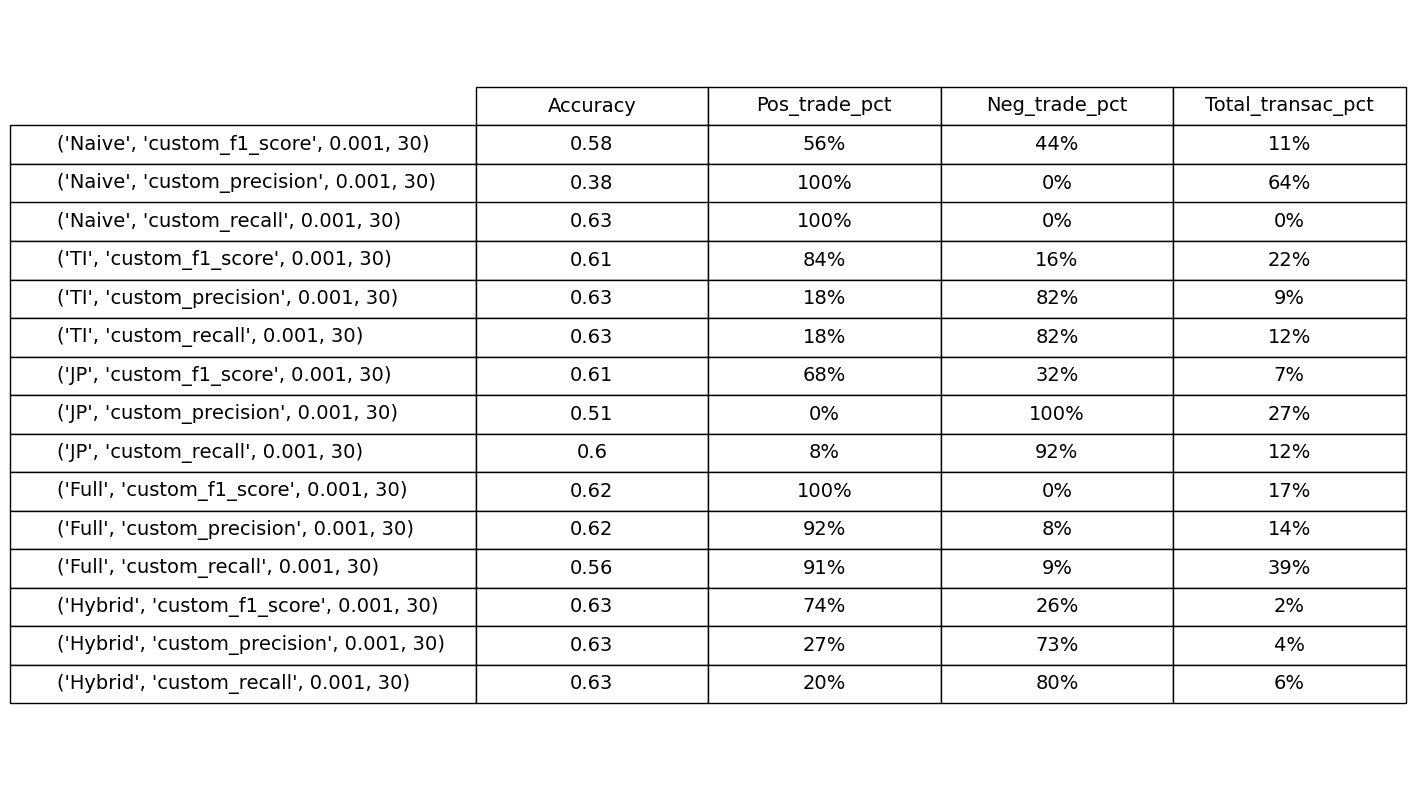

In [62]:
# Set up the figure with a white background
plt.figure(figsize=(12, 10), facecolor='white')  # Increase the figure size
sns.set_context("notebook", font_scale=1.8)  # Increase font scale for the whole plot
ax = plt.gca()

# Hide the axes
ax.axis('off')

# Define row colors: all rows with no color (white background)
row_colors = ['white'] * len(trade_summary_hour.index)

# Create the table with no color
table = ax.table(
    cellText=trade_summary_hour.values,
    colLabels=trade_summary_hour.columns,
    rowLabels=trade_summary_hour.index,
    cellLoc='center',
    loc='center',
    cellColours=[['white'] * len(trade_summary_hour.columns) for _ in range(len(trade_summary_hour))],  # No color for cells
    colColours=['white'] * len(trade_summary_hour.columns),  # No color for column labels
    rowColours=row_colors  # No color for row labels
)

# Adjust cell height to reduce crowding
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(color='black', fontsize=14)  # Increase font size for cell text
    cell.set_edgecolor('black')  # Set edge color to black
    
    # Adjust cell height for rows
    if i >= 0:  # Exclude column labels row
        cell.set_height(0.05)  # Set height for rows (adjust value as needed)

# Adjust font size for row labels
for i in range(len(trade_summary_hour.index)):
    cell = table[(i + 1, -1)]  # i + 1 because row labels are in the last column
    cell._text.set_fontsize(18)  # Increase font size for row labels

# Adjust font size for column labels
for j in range(len(trade_summary_hour.columns)):
    cell = table[(0, j)]  # Column labels are in the first row
    cell._text.set_fontsize(18)  # Increase font size for column labels

# Save the figure as a PNG
plt.savefig('lstm_trade_summary_hour.png', bbox_inches='tight', dpi=300)
plt.show()


In [67]:
trade_summary_day

Naive                              \
                                      Accuracy Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                                        
('custom_f1_score', 0.001, 30)            0.31          100%            0%   
('custom_precision', 0.001, 30)           0.19          100%            0%   
('custom_recall', 0.001, 30)              0.24          100%            0%   

                                                              SV  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                      49%     0.18   
('custom_precision', 0.001, 30)                    100%     0.19   
('custom_recall', 0.001, 30)                        78%     0.21   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                  72%           28%   
('custom_precision', 0.001, 30)                 22%           78%   
('custom_recall', 0.001, 30)                   100%            0%   

                                                              TI  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                     100%     0.24   
('custom_precision', 0.001, 30)                    100%     0.63   
('custom_recall', 0.001, 30)                        94%     0.19   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                 100%            0%   
('custom_precision', 0.001, 30)                  0%          100%   
('custom_recall', 0.001, 30)                   100%            0%   

                                                            Full  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                      92%     0.63   
('custom_precision', 0.001, 30)                      1%     0.19   
('custom_recall', 0.001, 30)                       100%     0.29   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                 100%            0%   
('custom_precision', 0.001, 30)                100%            0%   
('custom_recall', 0.001, 30)                    51%           49%   

                                                          Hybrid  \
                                      Total_transac_pct Accuracy   
('metric', 'learning_rate', 'epochs')                              
('custom_f1_score', 0.001, 30)                       0%     0.24   
('custom_precision', 0.001, 30)                     99%     0.63   
('custom_recall', 0.001, 30)                        89%     0.21   

                                                                   \
                                      Pos_trade_pct Neg_trade_pct   
('metric', 'learning_rate', 'epochs')                               
('custom_f1_score', 0.001, 30)                 100%            0%   
('custom_precision', 0.001, 30)                  0%          100%   
('custom_recall', 0.001, 30)                   100%            0%   

                                                         
                                      Total_transac_pct  
('metric', 'learning_rate', 'epochs')                    
('custom_f1_score', 0.001, 30)                      92%  
('custom_precision', 0.001, 30)             

In [69]:
trade_summary_day_naive = trade_summary_day.loc[:, pd.IndexSlice['Naive', :]]
trade_summary_day_naive.columns = trade_summary_day_naive.columns.droplevel(0)
trade_summary_day_naive.index =  pd.MultiIndex.from_tuples([
    ('Naive', 'custom_f1_score', 0.001, 30),
    ('Naive', 'custom_precision', 0.001, 30),
    ('Naive', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_day_JP = trade_summary_day.loc[:, pd.IndexSlice['SV', :]]
trade_summary_day_JP.columns = trade_summary_day_JP.columns.droplevel(0)
trade_summary_day_JP.index =  pd.MultiIndex.from_tuples([
    ('JP', 'custom_f1_score', 0.001, 30),
    ('JP', 'custom_precision', 0.001, 30),
    ('JP', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_day_TI = trade_summary_day.loc[:, pd.IndexSlice['TI', :]]
trade_summary_day_TI.columns = trade_summary_day_TI.columns.droplevel(0)
trade_summary_day_TI.index =  pd.MultiIndex.from_tuples([
    ('TI', 'custom_f1_score', 0.001, 30),
    ('TI', 'custom_precision', 0.001, 30),
    ('TI', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_day_Full = trade_summary_day.loc[:, pd.IndexSlice['Full', :]]
trade_summary_day_Full.columns = trade_summary_day_Full.columns.droplevel(0)
trade_summary_day_Full.index =  pd.MultiIndex.from_tuples([
    ('Full', 'custom_f1_score', 0.001, 30),
    ('Full', 'custom_precision', 0.001, 30),
    ('Full', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_day_Hybrid = trade_summary_day.loc[:, pd.IndexSlice['Hybrid', :]]
trade_summary_day_Hybrid.columns = trade_summary_day_Hybrid.columns.droplevel(0)
trade_summary_day_Hybrid.index =  pd.MultiIndex.from_tuples([
    ('Hybrid', 'custom_f1_score', 0.001, 30),
    ('Hybrid', 'custom_precision', 0.001, 30),
    ('Hybrid', 'custom_recall', 0.001, 30)
], names=['model', 'metric', 'learning_rate', 'epochs'])

trade_summary_day = pd.concat([trade_summary_day_naive, trade_summary_day_TI, trade_summary_day_JP, trade_summary_day_Full, trade_summary_day_Hybrid])
trade_summary_day

Accuracy Pos_trade_pct  \
model  metric           learning_rate epochs                           
Naive  custom_f1_score  0.001         30          0.31          100%   
       custom_precision 0.001         30          0.19          100%   
       custom_recall    0.001         30          0.24          100%   
TI     custom_f1_score  0.001         30          0.24          100%   
       custom_precision 0.001         30          0.63            0%   
       custom_recall    0.001         30          0.19          100%   
JP     custom_f1_score  0.001         30          0.18           72%   
       custom_precision 0.001         30          0.19           22%   
       custom_recall    0.001         30          0.21          100%   
Full   custom_f1_score  0.001         30          0.63          100%   
       custom_precision 0.001         30          0.19          100%   
       custom_recall    0.001         30          0.29           51%   
Hybrid custom_f1_score  0.001         30          0.24          100%   
       custom_precision 0.001         30          0.63            0%   
       custom_recall    0.001         30          0.21          100%   

                                             Neg_trade_pct Total_transac_pct  
model  metric           learning_rate epochs                                  
Naive  custom_f1_score  0.001         30                0%               49%  
       custom_precision 0.001         30                0%              100%  
       custom_recall    0.001         30                0%               78%  
TI     custom_f1_score  0.001         30                0%               92%  
       custom_precision 0.001         30              100%                1%  
       custom_recall    0.001         30                0%              100%  
JP     custom_f1_score  0.001         30               28%              100%  
       custom_precision 0.001         30               78%              100%  
       custom_recall    0.001         30                0%               94%  
Full   custom_f1_score  0.001         30                0%                0%  
       custom_precision 0.001         30                0%               99%  
       custom_recall    0.001         30               49%               89%  
Hybrid custom_f1_score  0.001         30                0%               92%  
       custom_precision 0.001         30              100%                1%  
       custom_recall    0.001         30                0%               94%

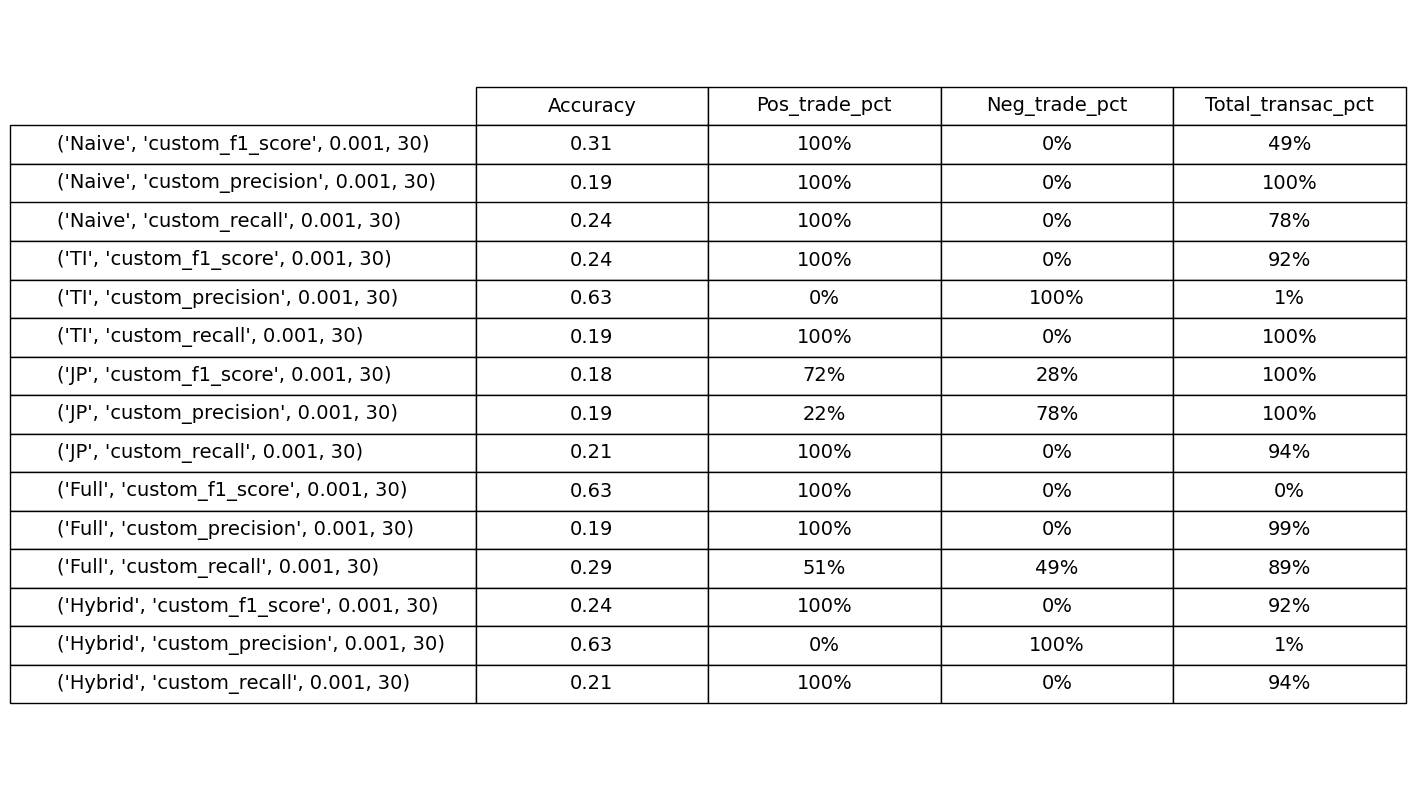

In [70]:
# Set up the figure with a white background
plt.figure(figsize=(12, 10), facecolor='white')  # Increase the figure size
sns.set_context("notebook", font_scale=1.8)  # Increase font scale for the whole plot
ax = plt.gca()

# Hide the axes
ax.axis('off')

# Define row colors: all rows with no color (white background)
row_colors = ['white'] * len(trade_summary_day.index)

# Create the table with no color
table = ax.table(
    cellText=trade_summary_day.values,
    colLabels=trade_summary_day.columns,
    rowLabels=trade_summary_day.index,
    cellLoc='center',
    loc='center',
    cellColours=[['white'] * len(trade_summary_day.columns) for _ in range(len(trade_summary_day))],  # No color for cells
    colColours=['white'] * len(trade_summary_day.columns),  # No color for column labels
    rowColours=row_colors  # No color for row labels
)

# Adjust cell height to reduce crowding
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(color='black', fontsize=14)  # Increase font size for cell text
    cell.set_edgecolor('black')  # Set edge color to black
    
    # Adjust cell height for rows
    if i >= 0:  # Exclude column labels row
        cell.set_height(0.05)  # Set height for rows (adjust value as needed)

# Adjust font size for row labels
for i in range(len(trade_summary_day.index)):
    cell = table[(i + 1, -1)]  # i + 1 because row labels are in the last column
    cell._text.set_fontsize(18)  # Increase font size for row labels

# Adjust font size for column labels
for j in range(len(trade_summary_day.columns)):
    cell = table[(0, j)]  # Column labels are in the first row
    cell._text.set_fontsize(18)  # Increase font size for column labels

# Save the figure as a PNG
plt.savefig('lstm_trade_summary_day.png', bbox_inches='tight', dpi=300)
plt.show()

# end
